## Step - 2: Create network of subjects

### Step - 2.1: Create similarity matrix and save to sql.

In [1]:
%pylab inline
import pandas as pd
import contributions
import votes
import bills
import sqlCommands
from peoplefinder import PeopleFinder
from operator import attrgetter
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from tqdm import tqdm

def subject_AandB(cur,A,B):
    #calculate the number of bills that have both subject A and subject B. Both are strings.
    #query for entires with both subjects.
    query = ("SELECT count(index) FROM bills WHERE category LIKE 'passage' AND (subjects LIKE '%%{" + A
                     + ",%%' OR subjects LIKE '%%,"+A+",%%' OR subjects LIKE '%%,"+A+"}%%') AND (subjects LIKE '%%{" + B 
                     +",%%' OR subjects LIKE '%%,"+B+",%%' OR subjects LIKE '%%,"+B+"}%%');")
    cur.execute(query)
    return ((cur.fetchall())[0][0])
    #get the size of the rows, i.e., the number of entries returned.
    #s = foo['index'].size
    #return s

def subject_AorB(engine,A,B):
    #calculate the number of bills that have either subject A and subject B. Both are strings.
    #query for entires with both subjects.
    #query1 = ("SELECT * FROM bills WHERE category LIKE 'passage' AND (subjects LIKE '%%{" + A
    #                 + ",%%' OR subjects LIKE '%%,"+A+",%%' OR subjects LIKE '%%,"+A+"}%%');")
    #query2 = ("SELECT * FROM bills WHERE category LIKE 'passage' AND (subjects LIKE '%%{" + A
    #                 + ",%%' OR subjects LIKE '%%,"+A+",%%' OR subjects LIKE '%%,"+A+"}%%');")
    #use query and put in DataFrame
    #foo = pd.read_sql_query(query1,engine)
    #get the size of the rows, i.e., the number of entries returned.
    #s1 = foo['index'].size
    #print(s1)
    #foo = pd.read_sql_query(query2,engine)
    #get the size of the rows, i.e., the number of entries returned.
    #s2 = foo['index'].size
    #print(s2)
    #s3 = subject_AandB(engine,A,B)
    #print(s3)
    result = s1 + s2 - s3
    return result

def subject_count(engine,A):
    query = ("SELECT * FROM bills WHERE category LIKE 'passage' AND (subjects LIKE '%%{" + A
                     + ",%%' OR subjects LIKE '%%,"+A+",%%' OR subjects LIKE '%%,"+A+"}%%');")
    #use query and put in DataFrame
    foo = pd.read_sql_query(query,engine)
    return (foo['index'].size)

def fast_subject_count(cur,A):
    query = ("SELECT count(index) FROM bills WHERE category LIKE 'passage' AND (subjects LIKE '%%{" + A
                     + ",%%' OR subjects LIKE '%%,"+A+",%%' OR subjects LIKE '%%,"+A+"}%%');")
    cur.execute(query)
    return ((cur.fetchall())[0][0])

def super_fast_subject_count(cur,A):
    query = ()
    return
    
def jaccard_similarity(cur,A,B,nA,nB):
    nAandB = subject_AandB(cur,A,B)
    result = nAandB/(nA+nB-nAandB)
    return result

def get_all_subjects(engine):
    query = "SELECT * FROM topics"
    foo = pd.read_sql_query(query, engine)
    return foo

def clean_subject(a):
    try:
        quoteloc = a.index("'") #may get issues with multiple single quotes in one topic.
        a = a[:quoteloc]+"'"+a[quoteloc:]
    except:
        pass #no quotes found
    #need to add " if there are any spaces in the subject
    try:
        quoteloc = a.index(" ") #will go to except if there are no spaces in the subject
        a = '\"'+a+'\"'
    except:
        pass #no spaces found
    return a

Populating the interactive namespace from numpy and matplotlib


In [2]:
#set up postgresql engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)
conn = psycopg2.connect("dbname='legislatr' user='lordluen' host='localhost'")
cur = conn.cursor()

In [3]:
#visualize bill number cutoff
subs = get_all_subjects(engine)
subs['q_subjects'] = subs['subjects'].map( lambda x: clean_subject(x))
subs['numBills'] = subs['q_subjects'].map( lambda x: fast_subject_count(cur,x))


In [4]:
#plot bill numbers
temp = np.asarray(subs['numBills'])
temp = np.sort(temp)
tdf = pd.DataFrame()
tdf['num'] = temp
tdf.head(-1)

,num
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39e84407b8>]], dtype=object)

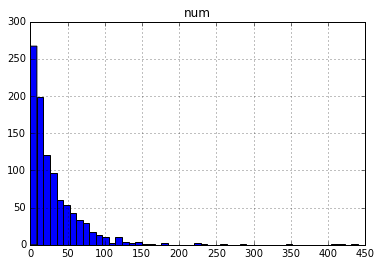

In [5]:
tdf.hist(bins=50)

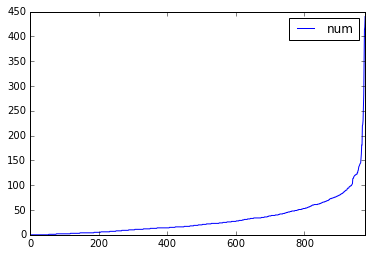

In [6]:
tdf.plot()

In [7]:
#get all subjects
subs = get_all_subjects(engine)
#change syntax to be correct for queries.
subs['q_subjects'] = subs['subjects'].map( lambda x: clean_subject(x))
#can probably get number of bills each subject is on and store it before the loop to speed it up a bit.
subs['numBills'] = subs['q_subjects'].map( lambda x: fast_subject_count(cur,x))
#delete subjects that are appear less than 10 times
subs = subs[subs.numBills >= 10]
#subs = subs[subs.numBills >= 100] #highest derivative

In [8]:
subs.head(-1)

,index,subjects,q_subjects,numBills
1,1,Abortion,Abortion,40
2,2,Academic performance and assessments,"""Academic performance and assessments""",17
3,3,Access Board,"""Access Board""",13
4,4,Accidents,Accidents,11
5,5,Accounting and auditing,"""Accounting and auditing""",73
7,7,Administrative Conference of the U.S.,"""Administrative Conference of the U.S.""",14
8,8,Administrative law and regulatory procedures,"""Administrative law and regulatory procedures""",284
9,9,Administrative remedies,"""Administrative remedies""",120
10,10,Adoption and foster care,"""Adoption and foster care""",14
13,13,Advanced technology and technological innovations,"""Advanced technology and technological innovat...",48


In [9]:
#dont touch yet...
#save subjects table to sql
sqlCommands.write_to_database(dbname,'subs',subs,engine)

In [23]:
subs_size = subs['subjects'].size
print('subs_size = ',subs_size)
subs_sim = np.zeros((subs_size,subs_size))
for i in tqdm(range(0,subs_size)):
    #print(i)
    a = subs['q_subjects'].iloc[i]
    na = subs['numBills'].iloc[i]
    for j in range(0,subs_size):
        if j < i:
            subs_sim[i,j] = subs_sim[j,i] #matrix is diagonal, so can cut loop time in half.
        else :
            b = subs['q_subjects'].iloc[j]
            nb = subs['numBills'].iloc[j]
            subs_sim[i,j]=jaccard_similarity(cur,a,b,na,nb)
cols = np.arange(subs_size)
rows = np.arange(subs_size)
ss_df = pd.DataFrame(data=subs_sim,index=rows,columns=cols)
sqlCommands.append_to_database(dbname,'subs_sim2',ss_df,engine)

subs_size =  40


100%|██████████| 40/40 [00:09<00:00,  4.01it/s]


In [24]:
ss_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.000000,0.320261,0.311728,0.232198,0.199052,0.221212,0.238532,0.191176,0.004286,0.453917,...,0.148368,0.277612,0.280802,0.239884,0.200573,0.246988,0.241279,0.188953,0.176638,0.293578
1,0.320261,1.000000,0.279412,0.152709,0.128713,0.177340,0.242268,0.169903,0.000000,0.219321,...,0.155440,0.173333,0.246696,0.157205,0.148649,0.213592,0.211982,0.206897,0.131818,0.295000
2,0.311728,0.279412,1.000000,0.328125,0.218121,0.306533,0.224299,0.316583,0.010830,0.311828,...,0.251282,0.217949,0.381818,0.305936,0.320574,0.302885,0.345972,0.220183,0.189427,0.320755
3,0.232198,0.152709,0.328125,1.000000,0.282443,0.370588,0.151961,0.298343,0.007561,0.256131,...,0.331288,0.387097,0.385000,0.392473,0.431034,0.363128,0.352632,0.213198,0.292553,0.338624
4,0.199052,0.128713,0.218121,0.282443,1.000000,0.353175,0.143333,0.270370,0.023962,0.311060,...,0.274510,0.262069,0.332180,0.400763,0.337079,0.348659,0.258621,0.239286,0.295203,0.271127
5,0.221212,0.177340,0.306533,0.370588,0.353175,1.000000,0.148325,0.379310,0.007491,0.283747,...,0.370370,0.348718,0.402985,0.508571,0.494118,0.353261,0.343590,0.232323,0.450292,0.343750
6,0.238532,0.242268,0.224299,0.151961,0.143333,0.148325,1.000000,0.141509,0.011236,0.225131,...,0.108911,0.183036,0.173554,0.156522,0.190698,0.172897,0.162996,0.144186,0.141553,0.192661
7,0.191176,0.169903,0.316583,0.298343,0.270370,0.379310,0.141509,1.000000,0.000000,0.282192,...,0.309942,0.261905,0.345972,0.378238,0.361702,0.195238,0.375000,0.255102,0.282051,0.220657
8,0.004286,0.000000,0.010830,0.007561,0.023962,0.007491,0.011236,0.000000,1.000000,0.026810,...,0.007722,0.007156,0.003448,0.007143,0.009107,0.007339,0.010791,0.009276,0.011070,0.012704
9,0.453917,0.219321,0.311828,0.256131,0.311060,0.283747,0.225131,0.282192,0.026810,1.000000,...,0.236264,0.272021,0.356383,0.305040,0.309783,0.261905,0.272727,0.222798,0.259259,0.289125


### Step - 2.2: Use similarity matrix to create graph and cluster.

In [30]:
%pylab inline
import pandas as pd
import contributions
import votes
import bills
import sqlCommands
from peoplefinder import PeopleFinder
from operator import attrgetter
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from tqdm import tqdm
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


In [31]:
#set up postgresql engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)
conn = psycopg2.connect("dbname='legislatr' user='lordluen' host='localhost'")
cur = conn.cursor()

In [32]:
#load subjects list and matrix of similarities
subs = pd.read_sql_table('subs',engine)
subs_sim = pd.read_sql_table('subs_sim',engine)

In [4]:
#load subjects list and matrix of similarities
subs = pd.read_sql_table('subs2',engine)
subs_sim = pd.read_sql_table('subs_sim2',engine)

In [33]:
subs.head(4)

,level_0,index,subjects,q_subjects,numBills
0,1,1,Abortion,Abortion,40
1,2,2,Academic performance and assessments,"""Academic performance and assessments""",17
2,3,3,Access Board,"""Access Board""",13
3,4,4,Accidents,Accidents,11


In [34]:
subs.describe()

,level_0,index,numBills
count,691.000000,691.000000,691.000000
mean,484.134588,484.134588,43.382055
std,283.220584,283.220584,44.063938
min,1.000000,1.000000,10.000000
25%,237.500000,237.500000,17.000000
50%,486.000000,486.000000,31.000000
75%,725.000000,725.000000,54.000000
max,977.000000,977.000000,440.000000


In [35]:
subs_sim.head(2)

,index,0,1,2,3,4,5,6,7,8,...,681,682,683,684,685,686,687,688,689,690
0,0,1.000000,0.017857,0.104167,0.0,0.141414,0.125000,0.062295,0.088435,0.058824,...,0.16129,0.070175,0.294872,0.220000,0.052632,0.129630,0.0,0.112903,0.050000,0.152174
1,1,0.017857,1.000000,0.000000,0.0,0.058824,0.068966,0.034364,0.014815,0.107143,...,0.00000,0.000000,0.083333,0.055556,0.026667,0.055556,0.0,0.150000,0.052632,0.000000


In [36]:
#load up a graph
G_subs = nx.Graph()
#add nodes to the graph
G_subs.add_nodes_from(subs['subjects'])

In [37]:
sim = subs_sim.iloc[0:,1:]
#don't do this.
#convert sim matrix into weighting for edges (1/r)-1.
#sim = (1/subs_sim.iloc[0:,1:]) - 1
#sim.head(4)

In [38]:
sim.describe() #I need stuff to run faster. So only keeping edges that are greater than 0.2.

,0,1,2,3,4,5,6,7,8,9,...,681,682,683,684,685,686,687,688,689,690
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,...,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,0.091731,0.043686,0.107606,0.034352,0.136123,0.183372,0.081234,0.092216,0.046645,0.127388,...,0.092666,0.077037,0.157518,0.143552,0.122379,0.173507,0.063859,0.178242,0.069822,0.175730
std,0.063565,0.062828,0.118076,0.057471,0.080292,0.177226,0.069150,0.065382,0.057153,0.084070,...,0.070720,0.069651,0.095504,0.100908,0.073298,0.149847,0.095526,0.123196,0.066554,0.183279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003279,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.055051,0.000000,0.037116,0.000000,0.076923,0.068966,0.036668,0.051471,0.000000,0.062019,...,0.050180,0.032971,0.083333,0.074547,0.071714,0.066667,0.000000,0.085657,0.030303,0.060606
50%,0.090361,0.031250,0.084746,0.019231,0.129412,0.142857,0.062718,0.083333,0.040404,0.126984,...,0.083333,0.066667,0.153846,0.129032,0.121951,0.144068,0.042105,0.163265,0.061728,0.131313
75%,0.125000,0.064516,0.150342,0.052290,0.185376,0.234492,0.107319,0.124612,0.066667,0.180000,...,0.131579,0.112942,0.216063,0.191899,0.165978,0.230769,0.090909,0.257143,0.095696,0.217708
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
#need to make a histogram of weights.
bleh = np.asarray(sim)
bleh = np.sort(bleh.flatten())
print(bleh.size)

477481


In [40]:
bleh_df = pd.DataFrame()
bleh_df['w'] = bleh
subs = subs[subs.numBills >= 10]
bleh_df = bleh_df[bleh_df.w > 0]



In [42]:
#calculate derivative of weights
bleh_sort = np.asarray(bleh_df.w)
for i in range(1000,1050):#len(bleh_sort)-40):
    d = np.mean(bleh_sort[i-20:i])-np.mean(bleh_sort[i:i+20])/(2.*20.)
    print(d)
bleh_dif = (bleh_sort[20:]-bleh_sort[0:-20])/(20)
bleh_dif2 = (bleh_dif[20:]-bleh_)
bleh_df_dif = pd.DataFrame()
bleh_df_dif['dw'] = bleh_dif

0.00790639461599
0.00790879592974
0.00791119724349
0.00791442621276
0.00791765518203
0.00792006625575
0.00792247732946
0.00792488840318
0.00792729947689
0.00793056262259
0.0079338257683
0.00793544314856
0.00793706052882
0.00793867790907
0.00794029528933
0.00794191266959
0.00794353004985
0.00794598194824
0.00794843384664
0.00795086461964
0.00795329539264
0.00795572616564
0.00795815693864
0.00796059765194
0.00796303836525
0.00796547907855
0.00796791979185
0.00797036050515
0.00797280121846
0.00797441064201
0.00797602006557
0.00797760818896
0.00797919631236
0.00798078443575
0.00798237255915
0.00798396068254
0.00798554880594
0.00798716483094
0.00798878085594
0.00799124163364
0.00799370241134
0.00799616318905
0.00799862396675
0.00800111634668
0.0080036087266
0.00800607962941
0.00800855053223
0.00801102143504
0.00801349233786
0.00801596324067


NameError: name 'bleh_' is not defined

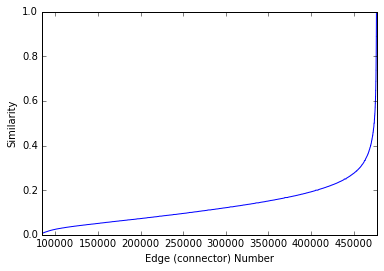

In [48]:
bleh_df.plot(legend=False).set(xlabel="Edge (connector) Number", ylabel="Similarity")

In [17]:
bleh_df_dif.plot()

NameError: name 'bleh_df_dif' is not defined

In [24]:
for i in tqdm(range(0,sim['0'].size)):
    for j in range(0,sim['0'].size):
        #loops to add edges. Should be able to drop the j loop, but not sure of proper syntax to greate a list of tuples.
        #would need to use G_subs.add_weighted_edges_from().
        #if weight is infinity, then no edge.
        w = sim[str(i)].iloc[j]
        #if np.isfinite(w) : #could limit to small edges as well (like less than 20)
        #if w > 0.4:
        if w > 0.3:    
        #if w > 0.18:
            G_subs.add_edge(subs['subjects'].iloc[i],subs['subjects'].iloc[j],weight=w)
        #G_subs.add_edge(subs['subjects'].iloc[i],subs['subjects'].iloc[j],weight=w)

100%|██████████| 691/691 [00:06<00:00, 106.74it/s]


In [25]:
#turn graph to undirected for clustering analysis.
G_subs_ud = G_subs.to_undirected()
G_subs_ud.remove_edges_from(G_subs_ud.selfloop_edges())


In [81]:
#plot graph, then decide how to define clusters.

G_subs_k1 = nx.k_core(G_subs_ud)


In [26]:
from cluster_method import girvan_newman
import itertools
from operator import itemgetter

def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight='weight')
    return max(centrality, key=centrality.get)

def heaviest(G):
    u, v, w = max(G.edges(data='weight'), key=itemgetter(2))
    return (u, v)

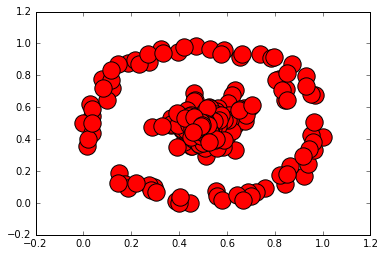

In [27]:
#plot network
pos = nx.spring_layout(G_subs_ud)
nx.draw_networkx_nodes(G_subs_ud,pos,size=10)
nx.draw_networkx_edges(G_subs_ud,pos,width=4)

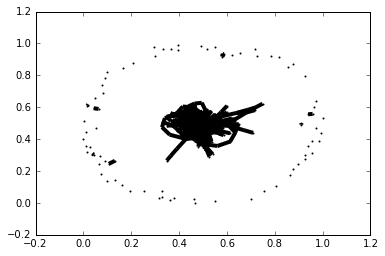

In [28]:
H = G_subs_ud.subgraph(subs['subjects'].iloc[:])
pos = nx.spring_layout(H)
nx.draw_networkx_nodes(H,pos,node_size=1)
nx.draw_networkx_edges(H,pos,width=4)

In [179]:
k = 20
comp = girvan_newman(G_subs_ud, most_valuable_edge=most_central_edge)
#comp = girvan_newman(G_subs_ud, most_valuable_edge=heaviest)
#comp = girvan_newman(G_subs_ud)
#tuple(sorted(c) for c in next(comp))
cc = list()
for communities in itertools.islice(comp,k):
    cc.append(tuple(sorted(c) for c in communities))

In [180]:
#plot number of clusters to number of iterations.
niters = np.arange(k)+1
nclusters = np.zeros(k)
for i in range(0,k):
    nclusters[i] = len(cc[i])

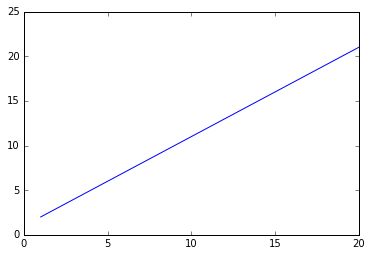

In [181]:
#plot it.
plt.plot(niters,nclusters)

In [169]:
print(len(cc[6]))

22


In [155]:
print(cc[-1])

(['Aviation and airports', 'Government employee pay, benefits, personnel management', 'Hazardous wastes and toxic substances', 'Research administration and funding', 'Research and development'], ['Defense spending', 'Department of Defense', 'Military operations and strategy', 'Military personnel and dependents', 'Terrorism'], ['Appropriations', 'Executive agency funding and structure', 'Government trust funds'], ['Congress', 'House of Representatives', 'Legislative rules and procedure'], ['Administrative remedies'], ['Health care costs and insurance'], ['Oil and gas'], ['Alternative and renewable resources', 'Energy efficiency and conservation'], ['Administrative law and regulatory procedures', 'Congressional oversight', 'Government information and archives'], ['Computers and information technology'], ['Education programs funding', 'Elementary and secondary education', 'Higher education'], ['Advisory bodies'], ['Tax administration and collection, taxpayers'], ['Licensing and registrati

In [157]:
foo = cc[-1]
print(type(foo))
towrite = pd.DataFrame()
towrite['subjects'] = foo

<class 'tuple'>


In [160]:
towrite.head(-1)

,subjects
0,"[Aviation and airports, Government employee pa..."
1,"[Defense spending, Department of Defense, Mili..."
2,"[Appropriations, Executive agency funding and ..."
3,"[Congress, House of Representatives, Legislati..."
4,[Administrative remedies]
5,[Health care costs and insurance]
6,[Oil and gas]
7,"[Alternative and renewable resources, Energy e..."
8,"[Administrative law and regulatory procedures,..."
9,[Computers and information technology]


In [159]:
towrite = pd.DataFrame()
towrite['subjects'] = foo
sqlCommands.write_to_database(dbname,'subs_lessbills_clusters',towrite,engine)

In [136]:
print(len(foo))
print(foo)

19
['Administrative law and regulatory procedures', 'Appropriations', 'Aviation and airports', 'Congressional oversight', 'Defense spending', 'Department of Defense', 'Executive agency funding and structure', 'Government employee pay, benefits, personnel management', 'Government information and archives', 'Government studies and investigations', 'Government trust funds', 'Hazardous wastes and toxic substances', 'Military operations and strategy', 'Military personnel and dependents', 'Public contracts and procurement', 'Research administration and funding', 'Research and development', 'Rural conditions and development', 'Terrorism']


In [111]:
bar = cc[0][1:]

In [118]:
towrite = pd.DataFrame()
towrite['subjects'] = bar
sqlCommands.write_to_database(dbname,'subs_morebills_cloud',towrite,engine)

In [112]:
print(len(bar))

249


In [108]:
print(cc[-1])

(['Access Board', 'Administrative Conference of the U.S.', 'Administrative law and regulatory procedures', 'Afghanistan', 'Africa', 'Agricultural conservation and pollution', 'Agricultural insurance', 'Agricultural marketing and promotion', 'Agricultural practices and innovations', 'Agricultural prices, subsidies, credit', 'Agricultural research', 'Agricultural trade', 'Alliances', 'Alternative and renewable resources', 'American Battle Monuments Commission', 'American Samoa', 'Animal and plant health', 'Appalachian Regional Commission', 'Appropriations', 'Aquatic ecology', 'Arab-Israeli relations', 'Architect of the Capitol', 'Arkansas', 'Armed Forces Retirement Home', 'Armed forces and national security', 'Arms control and nonproliferation', 'Army Corps of Engineers', 'Art, artists, authorship', 'Asia', 'Assault and harassment offenses', 'Atmospheric science and weather', 'Aviation and airports', 'Bahrain', 'Bankruptcy', 'Birds', 'Broadcasting Board of Governors', 'Burma', 'Buy Ameri

In [19]:
print(cc[1])

(['Abortion', 'Academic performance and assessments', 'Access Board', 'Accidents', 'Accounting and auditing', 'Administrative Conference of the U.S.', 'Administrative law and regulatory procedures', 'Administrative remedies', 'Adoption and foster care', 'Advanced technology and technological innovations', 'Advisory bodies', 'Afghanistan', 'Africa', 'Aging', 'Agricultural conservation and pollution', 'Agricultural insurance', 'Agricultural marketing and promotion', 'Agricultural practices and innovations', 'Agricultural prices, subsidies, credit', 'Agricultural research', 'Agricultural trade', 'Agriculture and food', 'Air quality', 'Alabama', 'Alaska', 'Alaska Natives and Hawaiians', 'Alcoholic beverages', 'Alliances', 'Alternative and renewable resources', 'Alternative dispute resolution, mediation, arbitration', 'American Battle Monuments Commission', 'American Samoa', 'Animal and plant health', 'Animal protection and human-animal relationships', 'Appalachian Regional Commission', 'Ap

In [ ]:
cc = list()
comp = girvan_newman(G_subs_ud)
for communities in itertools.islice(comp,k):
    cc.append(tuple(sorted(c) for c in communities))

In [17]:
print(cc[1])

(['Abortion', 'Academic performance and assessments', 'Access Board', 'Accidents', 'Accounting and auditing', 'Administrative Conference of the U.S.', 'Administrative law and regulatory procedures', 'Administrative remedies', 'Adoption and foster care', 'Advanced technology and technological innovations', 'Advisory bodies', 'Afghanistan', 'Africa', 'Aging', 'Agricultural conservation and pollution', 'Agricultural insurance', 'Agricultural marketing and promotion', 'Agricultural practices and innovations', 'Agricultural prices, subsidies, credit', 'Agricultural research', 'Agricultural trade', 'Agriculture and food', 'Air quality', 'Alabama', 'Alaska', 'Alaska Natives and Hawaiians', 'Alcoholic beverages', 'Alliances', 'Alternative and renewable resources', 'Alternative dispute resolution, mediation, arbitration', 'American Battle Monuments Commission', 'American Samoa', 'Animal and plant health', 'Animal protection and human-animal relationships', 'Appalachian Regional Commission', 'Ap

In [14]:
print(cc[1])

(['Abortion', 'Academic performance and assessments', 'Access Board', 'Accidents', 'Accounting and auditing', 'Administrative Conference of the U.S.', 'Administrative law and regulatory procedures', 'Administrative remedies', 'Adoption and foster care', 'Advanced technology and technological innovations', 'Advisory bodies', 'Afghanistan', 'Africa', 'Aging', 'Agricultural conservation and pollution', 'Agricultural insurance', 'Agricultural marketing and promotion', 'Agricultural practices and innovations', 'Agricultural prices, subsidies, credit', 'Agricultural research', 'Agricultural trade', 'Agriculture and food', 'Air quality', 'Alabama', 'Alaska', 'Alaska Natives and Hawaiians', 'Alcoholic beverages', 'Alliances', 'Alternative and renewable resources', 'Alternative dispute resolution, mediation, arbitration', 'American Battle Monuments Commission', 'American Samoa', 'Animal and plant health', 'Animal protection and human-animal relationships', 'Appalachian Regional Commission', 'Ap